In [1]:
# Analysis for CT Pretrial Detainees
# (Springboard Capstone 1)
# 2019, Misty M. Giles

# Set up plotting  
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns

# ???  Am I using this?
from datetime import datetime as date

# Import standard packages
import numpy as np
import pandas as pd
import scipy.stats as stats

# Import misc tools
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

# Import verification tools
from sklearn.model_selection import cross_val_score

# Import preprocessing tools
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import StandardScaler

# Import models
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
from sklearn.multiclass import OneVsRestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

# Select the file created in CT_csv (unit 5 data wrangling assignment)
file = 'detainees_classed_offenses.csv'

C:\Users\Misty\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
# Read in the file
df = pd.read_csv(file, parse_dates=['download_date', 'latest_admission_date'])

# Change from previous notebooks to drop the single case of 'UM' at the 
# beginning -- inclusion prevents use of 'stratify'.)
df['offense_class'] = [offense[-2:] if offense.endswith(('AM','BM','CM','DM',' M', 
                       'AF','BF','CF','DF',' F')) else np.nan for offense in df.offense]

# Days that CT says a detainee has been in the system.  This doesn't account for
# some detainees.  There are 730 days in the dataset, and the state says that entrance 
# dates over a year before could be original entrance date but are definitely not to be
# trusted.  The days column will be capped at 1,095 (730 + 365).  
df.days = [int(time[:-23]) for time in df.days]
df.days = [time if time <= 1095 else 1095 for time in df.days]

#df = df.loc[df.days<1095]

# Check that everything worked.  There should be 0 null values.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28808 entries, 0 to 28807
Data columns (total 13 columns):
download_date            28808 non-null datetime64[ns]
identifier               28808 non-null object
latest_admission_date    28808 non-null datetime64[ns]
race                     28808 non-null object
gender                   28808 non-null object
age                      28808 non-null int64
bond_amount              28808 non-null int64
offense                  28808 non-null object
facility                 28808 non-null object
detainer                 28808 non-null object
offense_class            28807 non-null object
days                     28808 non-null int64
counts                   28808 non-null int64
dtypes: datetime64[ns](2), int64(4), object(7)
memory usage: 2.9+ MB


In [3]:
# Only working with the 94% under 80k.
#df = df.loc[df.bond_amount<=80000]
#print(df.info())

# Separate out the two datasets, misdemeanor (primary) and felony.
misdemeanor_df = df.loc[df['offense_class'].str.endswith('M',na=False)].reset_index(
    drop=True).rename(index=str, columns={'offense_class_ M':'offense_class_M'})

# Change race, gender, facility, and detainer to category type and verify.
misdemeanor_df.race = misdemeanor_df.race.astype('category')
misdemeanor_df.gender = misdemeanor_df.gender.astype('category')
misdemeanor_df.facility = misdemeanor_df.facility.astype('category')
misdemeanor_df.detainer = misdemeanor_df.detainer.astype('category')
misdemeanor_df.offense_class = misdemeanor_df.offense_class.astype('category')

# Divide the misdemeanor data into pre-enactment and post.
mis_pre_df = misdemeanor_df.loc[misdemeanor_df.download_date < '2017-07-01']
mis_post_df = misdemeanor_df.loc[misdemeanor_df.download_date >= '2017-07-01']
mis_post_df = mis_post_df.loc[mis_post_df.download_date < '2018-07-01']
mis_outofbounds_df = misdemeanor_df.loc[misdemeanor_df.download_date >= '2018-07-01']
mis_df = pd.concat([mis_pre_df, mis_post_df])

# Check that everything worked.  There should be 0 null values.
misdemeanor_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9663 entries, 0 to 9662
Data columns (total 13 columns):
download_date            9663 non-null datetime64[ns]
identifier               9663 non-null object
latest_admission_date    9663 non-null datetime64[ns]
race                     9663 non-null category
gender                   9663 non-null category
age                      9663 non-null int64
bond_amount              9663 non-null int64
offense                  9663 non-null object
facility                 9663 non-null category
detainer                 9663 non-null category
offense_class            9663 non-null category
days                     9663 non-null int64
counts                   9663 non-null int64
dtypes: category(5), datetime64[ns](2), int64(4), object(2)
memory usage: 1.0+ MB


### Gender categorization:
1. Define data and target from the pre-enactment dataframe
2. Split, preprocess, and fit
3. Test the accuracy on pre-enactment test data
4. See what happens with the post-enactment data

In [15]:
len(mis_pre_df.loc[mis_pre_df.gender=='M'])/len(mis_pre_df.gender)

0.8271604938271605

In [5]:
# Define data and target
X = mis_pre_df[['bond_amount','days','age']]
y = mis_pre_df.gender.ravel()

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.3,stratify=y)

In [6]:
# Define data and target
X = mis_pre_df[['bond_amount','days','age']]
y = mis_pre_df.gender.ravel()

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.3,stratify=y)

# Rescale the data
scaler = MinMaxScaler()

# Classifier
clf = LogisticRegression()

pl = Pipeline([
        ('scaler', scaler),
        ('clf', clf)
    ])

pl.fit(X_train,y_train)
print("Accuracy, gender (training): %0.4f" % (pl.score(X_train,y_train)))

# Print the accuracy
scores = cross_val_score(pl, X_test, y_test, cv=5) 
print("Accuracy, gender (test): %0.4f (+/- %0.4f)" % (scores.mean(), scores.std() * 2))

Accuracy, gender (training): 0.8273
Accuracy, gender (test): 0.8269 (+/- 0.0035)


In [7]:
# Utility function to report best scores
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

            
from scipy.stats import uniform
            
# Create regularization penalty space
penalty = ['l1', 'l2']

# Create regularization hyperparameter distribution using uniform distribution
C = uniform(loc=0, scale=4)

# Create hyperparameter options
hyperparameters = dict(C=C, penalty=penalty)

# run randomized search
n_iter_search = 20
random_search = RandomizedSearchCV(clf, hyperparameters, n_iter=20, cv=5)

random_search.fit(X_train, y_train)
print("RandomizedSearchCV for %d candidates"
      " parameter settings." % (n_iter_search))
report(random_search.cv_results_)

RandomizedSearchCV for 20 candidates parameter settings.
Model with rank: 1
Mean validation score: 0.827 (std: 0.000)
Parameters: {'C': 1.3828121822763997, 'penalty': 'l1'}

Model with rank: 1
Mean validation score: 0.827 (std: 0.000)
Parameters: {'C': 1.4213104482586552, 'penalty': 'l1'}

Model with rank: 1
Mean validation score: 0.827 (std: 0.000)
Parameters: {'C': 2.737501377502344, 'penalty': 'l1'}

Model with rank: 1
Mean validation score: 0.827 (std: 0.000)
Parameters: {'C': 1.2208183899602574, 'penalty': 'l1'}

Model with rank: 1
Mean validation score: 0.827 (std: 0.000)
Parameters: {'C': 2.9427327759019284, 'penalty': 'l1'}

Model with rank: 1
Mean validation score: 0.827 (std: 0.000)
Parameters: {'C': 3.062989982152274, 'penalty': 'l2'}

Model with rank: 1
Mean validation score: 0.827 (std: 0.000)
Parameters: {'C': 2.3058054708328575, 'penalty': 'l2'}

Model with rank: 1
Mean validation score: 0.827 (std: 0.000)
Parameters: {'C': 0.10828909963839806, 'penalty': 'l2'}

Model wi

### About 0.823 of the sampled detainees over both years are male, so out-of-box classifiers give about 0.823 accuracy.  So far, I haven't found a set of predictors that improve over guessing.  Below is a random forest classifier with the feature importance plotted.  The three most important features are the ones used in the original linear regression above.

Accuracy, gender (test): 0.7858 (+/- 0.0232)


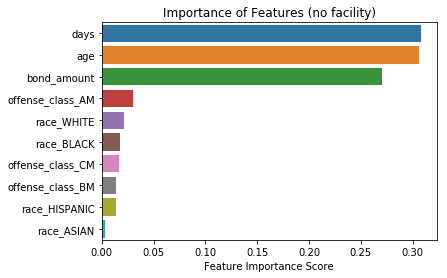

In [8]:
# Define data and target
X = mis_pre_df[['bond_amount','days','age','offense_class','race']]
X = pd.get_dummies(X,columns=['offense_class','race'],drop_first=True)#.drop('race_ASIAN',axis=1)
y = mis_pre_df.gender.ravel()

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.3,stratify=y)

# Rescale the data
scaler = MinMaxScaler()

# Classifier
#clf = DecisionTreeClassifier()
clf = RandomForestClassifier(n_estimators=100,max_features=None)
clf.fit(X_train,y_train)
scores = cross_val_score(clf, X_test, y_test, cv=5) 
print("Accuracy, gender (test): %0.4f (+/- %0.4f)" % (scores.mean(), scores.std() * 2))

clf.feature_importances_

feature_imp = pd.Series(clf.feature_importances_,index=X.columns).sort_values(ascending=False)
_ = sns.barplot(x=feature_imp, y=feature_imp.index)
_ = plt.xlabel('Feature Importance Score')
_ = plt.title('Importance of Features (no facility)')

In [9]:
# Utility function to report best scores
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

param_dist = {"max_depth": [2, 3, None],
              "max_features": [.1, .2, .3, .4, .5, .6, .7, .8, .9, 1.0],
              "min_samples_split": [2, 3, 4],
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]}

# run randomized search
n_iter_search = 20
random_search = RandomizedSearchCV(clf, param_distributions=param_dist,
                                   n_iter=n_iter_search, cv=5)

random_search.fit(X_train, y_train)
print("RandomizedSearchCV for %d candidates"
      " parameter settings." % (n_iter_search))
report(random_search.cv_results_)

RandomizedSearchCV for 20 candidates parameter settings.
Model with rank: 1
Mean validation score: 0.827 (std: 0.000)
Parameters: {'min_samples_split': 2, 'max_features': 0.4, 'max_depth': 3, 'criterion': 'entropy', 'bootstrap': True}

Model with rank: 1
Mean validation score: 0.827 (std: 0.000)
Parameters: {'min_samples_split': 4, 'max_features': 0.1, 'max_depth': 3, 'criterion': 'gini', 'bootstrap': True}

Model with rank: 1
Mean validation score: 0.827 (std: 0.000)
Parameters: {'min_samples_split': 4, 'max_features': 0.2, 'max_depth': 3, 'criterion': 'gini', 'bootstrap': False}

Model with rank: 1
Mean validation score: 0.827 (std: 0.000)
Parameters: {'min_samples_split': 4, 'max_features': 0.1, 'max_depth': 2, 'criterion': 'entropy', 'bootstrap': True}

Model with rank: 1
Mean validation score: 0.827 (std: 0.000)
Parameters: {'min_samples_split': 2, 'max_features': 0.1, 'max_depth': 3, 'criterion': 'entropy', 'bootstrap': True}

Model with rank: 1
Mean validation score: 0.827 (std:

### It is possible to create a predictor that is 100% correct for gender if you include the facility.  CT only has one facility for housing both pretrial and sentenced women.  (Source: https://portal.ct.gov/DOC/Facility/York-CI)

Accuracy, gender (test): 1.0000 (+/- 0.0000)


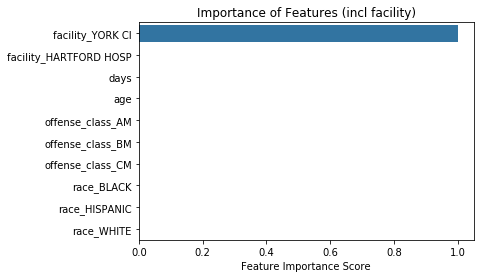

In [10]:
# Define data and target
X = mis_pre_df[['bond_amount','days','age','offense_class','race','facility']]
X = pd.get_dummies(X,columns=['offense_class','race','facility'],drop_first=True).drop('race_ASIAN',axis=1)
y = mis_pre_df.gender.ravel()

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.3,stratify=y)

# Rescale the data
scaler = MinMaxScaler()

# Classifier
#clf = DecisionTreeClassifier()
clf = RandomForestClassifier(n_estimators=100,max_features=None)
clf.fit(X_train,y_train)
scores = cross_val_score(clf, X_test, y_test, cv=5) 
print("Accuracy, gender (test): %0.4f (+/- %0.4f)" % (scores.mean(), scores.std() * 2))

clf.feature_importances_

feature_imp = pd.Series(clf.feature_importances_,index=X.columns).sort_values(ascending=False)
# Restrict the features available on the y-axis so you can read them
_ = sns.barplot(x=feature_imp[:10], y=feature_imp.index[:10])
_ = plt.xlabel('Feature Importance Score')
_ = plt.title('Importance of Features (incl facility)')

In [11]:
# Define data and target
X = mis_pre_df[['bond_amount','days','age']]
y = mis_pre_df.gender.ravel()

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.3,stratify=y)

# Rescale the data
scaler = StandardScaler()

# Classifier
clf = OneVsRestClassifier(LogisticRegression())

pl = Pipeline([
        ('scaler', scaler),
        ('clf', clf)
    ])

pl.fit(X_train,y_train)
print("Accuracy, gender (training): %0.4f" % (pl.score(X_train,y_train)))

# Print the accuracy
scores = cross_val_score(pl, X_test, y_test, cv=5) 
print("Accuracy, gender (test): %0.4f (+/- %0.4f)" % (scores.mean(), scores.std() * 2))

Accuracy, gender (training): 0.8273
Accuracy, gender (test): 0.8269 (+/- 0.0035)


In [12]:
# Define data and target
X = mis_pre_df[['bond_amount','days','age']]
y = mis_pre_df.gender.ravel()

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.3,stratify=y)

# Rescale the data
scaler = Normalizer()

# Classifier
clf = KNeighborsClassifier(n_neighbors=31)

pl = Pipeline([
        ('scaler', scaler),
        ('clf', clf)
    ])

pl.fit(X_train,y_train)
print("Accuracy, gender (training): %0.4f" % (pl.score(X_train,y_train)))

# Print the accuracy
scores = cross_val_score(pl, X_test, y_test, cv=5) 
print("Accuracy, gender (test): %0.4f (+/- %0.4f)" % (scores.mean(), scores.std() * 2))

Accuracy, gender (training): 0.8273
Accuracy, gender (test): 0.8243 (+/- 0.0127)


### Offense class and race q&d below.  The numbers are too similar in the gender for me to figure out if I'm doing something wrong.

In [13]:
# Define data and target
X = mis_pre_df[['bond_amount','days','age']]
y = mis_pre_df.offense_class.ravel()

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.3,stratify=y)

# Rescale the data
scaler = MinMaxScaler()

# Classifier
clf = LogisticRegression()

pl = Pipeline([
        ('scaler', scaler),
        ('clf', clf)
    ])

pl.fit(X_train,y_train)
print("Accuracy, offense class (training): %0.4f" % (pl.score(X_train,y_train)))

# Print the accuracy
scores = cross_val_score(pl, X_test, y_test, cv=5) 
print("Accuracy, offense class (test): %0.4f (+/- %0.4f)" % (scores.mean(), scores.std() * 2))

Accuracy, offense class (training): 0.7438
Accuracy, offense class (test): 0.7438 (+/- 0.0065)


In [14]:
# Define data and target
X = mis_pre_df[['bond_amount','days','age']]
y = mis_pre_df.race.ravel()

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.3,stratify=y)

# Rescale the data
scaler = MinMaxScaler()

# Classifier
clf = LogisticRegression()

pl = Pipeline([
        ('scaler', scaler),
        ('clf', clf)
    ])

pl.fit(X_train,y_train)
print("Accuracy, race (training): %0.4f" % (pl.score(X_train,y_train)))

# Print the accuracy
scores = cross_val_score(pl, X_test, y_test, cv=5) 
print("Accuracy, race (test): %0.4f (+/- %0.4f)" % (scores.mean(), scores.std() * 2))

Accuracy, race (training): 0.4259
Accuracy, race (test): 0.4405 (+/- 0.0178)
